In [1]:
# Import libraries
import warnings
import IPython
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import scipy.stats as stats
from pylab import rcParams
import pandas as pd
import sys
sys.path.append('../')

# Import RadDBS-QSM modules
import util
import loader
import extract
import train

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Find the repository path
raddbs_path = loader.get_raddbs_path(
    "/".join(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[-5:]))
nii_dir = '/data/nii/chh/orig/'

In [3]:
# Assuming `nii_dir` input contains subdirectories `qsm`, `seg`, and `masks`
segs,qsms,n_cases = loader.s1data(raddbs_path,nii_dir,False)

In [4]:
# Load clinical variables
# Remove LEDD?
df = pd.read_csv(Path(raddbs_path+'/data/xlxs/updrs_iii_chh_cvs.csv'))
age,sex,dd,ledd,subsc,pre_updrs_off,pre_updrs_on,post_updrs_off,per_change,lct_change = loader.s1cvdata(df,segs,raddbs_path,nii_dir,False)

In [5]:
# Obtain the feature value matrix X, feature labels K, and ROIs R
X_all_c,K_all_c,R_all_c = extract.feature_matrix(raddbs_path,segs,qsms,subsc,reextract=1)

Extracting features for subject 1.0 and appending feature matrix with vector of length 1689
Extracting features for subject 2.0 and appending feature matrix with vector of length 1689
Extracting features for subject 3.0 and appending feature matrix with vector of length 1689
Extracting features for subject 4.0 and appending feature matrix with vector of length 1689
Extracting features for subject 5.0 and appending feature matrix with vector of length 1689
Extracting features for subject 6.0 and appending feature matrix with vector of length 1689
Extracting features for subject 7.0 and appending feature matrix with vector of length 1689
Extracting features for subject 8.0 and appending feature matrix with vector of length 1689
Extracting features for subject 9.0 and appending feature matrix with vector of length 1689
Extracting features for subject 10.0 and appending feature matrix with vector of length 1689
Extracting features for subject 11.0 and appending feature matrix with vector o

Estimator predicts 0.7741 for case with 0.72 and selected CV 4 and 86 minority cases using random state 1 and sample size (418, 388)
Estimator predicts 0.591 for case with 0.47 and selected CV 4 and 83 minority cases using random state 1 and sample size (418, 2388)
Estimator predicts 0.8701 for case with 0.69 and selected CV 2 and 86 minority cases using random state 1 and sample size (418, 388)
Estimator predicts 0.7329 for case with 0.42 and selected CV 5 and 83 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.2717 for case with 0.15 and selected CV 3 and 163 minority cases using random state 1 and sample size (429, 6388)
Estimator predicts 0.577 for case with 0.44 and selected CV 5 and 83 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.8324 for case with 0.88 and selected CV 5 and 84 minority cases using random state 1 and sample size (418, 6388)
Estimator predicts 0.509 for case with 0.4 and selected CV 5 and 

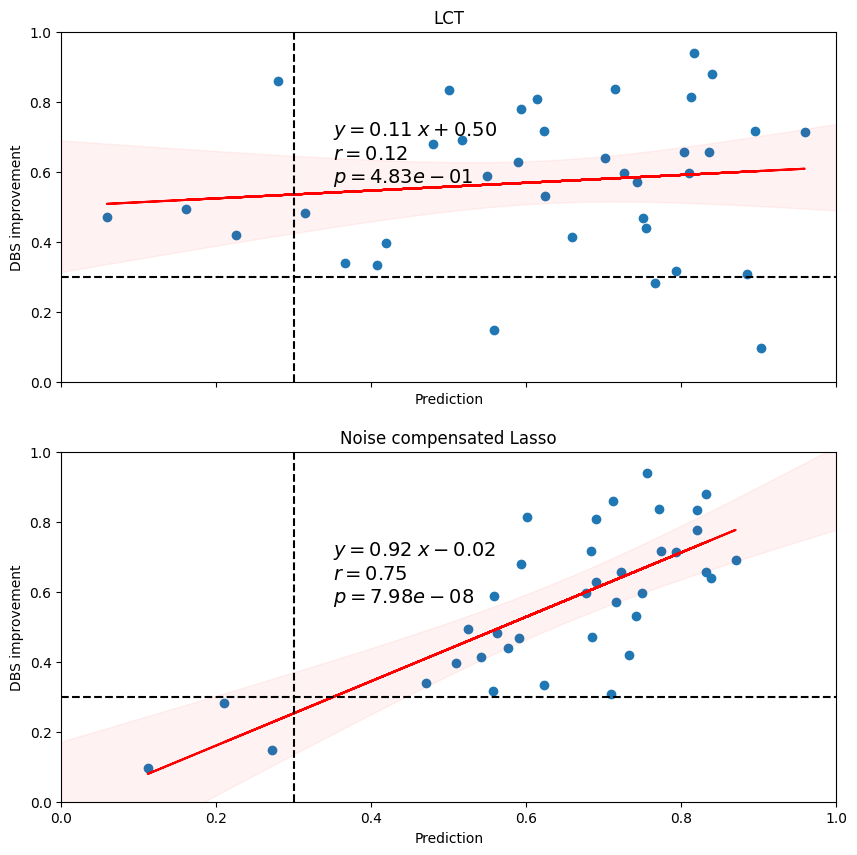

In [ ]:
# Train estimators
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
results_ls_aug = train.train_estimator(subsc,X_all_c,K_all_c,per_change,pre_updrs_on,age,sex,dd,None,'nc_iid_q',True,True,1,True)
util.eval_prediction(np.vstack((lct_change,results_ls_aug)),per_change,['LCT','Noise compensated Lasso'],[20,5])